# Exam, Part 2

A dynamic study of CAPM and "betting against beta." The main task involves building a trading strategy that bets against CAPM. It is not sure that it will be a success.

In [6]:
using Printf, Dates, Statistics, DelimitedFiles, Plots   #you shouldn't need any other packages

include("jlFiles/printmat.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :svg)

# Load Data

a. Import `Data/100_Portfolios_10x10.CSV` and convert all `-99.99` to `NaN`. Extract columns `2:end` and call that matrix `R`.

b. Import `Data/FFmFactors.csv` and extract `Rf` and `Rme` (columns 5 and 2).

c. Calculate excess returns as `Re = R .- Rf`

d. There are a few missing values in `Re`. For simplicity, convert them to 0.

In [3]:
File1 = "Data/100_Portfolios_10x10.CSV"
x   = readdlm(File1,',',skipstart=1)          #reading the csv file
ym  = round.(Int,x[:,1])                      #yearmonth, like 200712
dN  = Date.(string.(ym),"yyyymm")             #convert to Julia Date
R   = convert.(Float64,x[:,2:end])
replace!(R,-99.99=>NaN)                       #missing=>NaN

File2 = "Data/FFmFactors.csv"
x   = readdlm(File2,',',skipstart=1)          #reading the csv file
Rf  = x[:,5]
Rme = x[:,2]

Re  = R .- Rf
replace!(x->isunordered(x) ? 0 : x,Re)        #set missing Re to 0: as if no investment
(T,n) = size(Re)

(756, 100)

# Task 1: CAPM Regressions over Moving Data Windows

Let `x = [Rme ones(T)]`. Estimate the regression `Re[t-59:t,i]` on `x[t-59:t]` and record the slope cofefficient (that is, the coefficient on `Rme`) results in a matrix (`b[t,i]`).

Plot `b[:,11]` and `b[:,89]` in a time series plot, that is, for asset 11 and 89.

In [31]:
# Given: Re, Rf, Rme, R
# Re = Rf + β*(Rm - Rf)
# β = Covariance (Re, Rm) / Variance (Rm)
window_size = 60
b = zeros(T, n) # betas, T = number of time periods, n = number of assets
for i in 1:n  # Loop over each asset
    for t in window_size:T
        asset_returns = Re[t-window_size+1:t, i]
        market_excess_returns = Rme[t-window_size+1:t]
        cov_re_rme = cov(asset_returns, market_excess_returns)
        var_rme = var(market_excess_returns)

        b[t, i] = cov_re_rme / var_rme
    end
end

[1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]

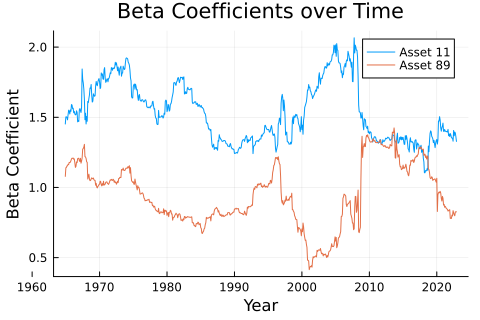

In [32]:
year_only(x) = Dates.format(Date(x), "yyyy")

start_index_11 = findfirst(x -> x != 0, b[:, 11])
start_index_89 = findfirst(x -> x != 0, b[:, 89])

plot_dates_11 = dN[start_index_11:end]
plot_dates_89 = dN[start_index_89:end]
plot_betas_11 = b[start_index_11:end, 11]
plot_betas_89 = b[start_index_89:end, 89]

start_year = 1960
end_year = Dates.year(maximum(plot_dates_89))
next_decade = Int(ceil(end_year / 10) * 10)  # Calculate the next decade year
year_ticks = collect(start_year:10:next_decade)  # Generate ticks for every 10 yearsif end_year % 10 != 0
date_ticks = [Date(y, 1, 1) for y in year_ticks]
print(year_ticks)

plot(plot_dates_11, plot_betas_11, label = "Asset 11", title = "Beta Coefficients over Time", xlabel = "Year", ylabel = "Beta Coefficient", xticks = (date_ticks, string.(year_ticks)), legend = :topright)
plot!(plot_dates_89, plot_betas_89, label = "Asset 89")

# Task 2: Rank Assets According to the Betas

a. For each period `t`, rank the assets according to the beta estimated over `t-59:t`, that is, rank `b[t,:]`. Clearly, this calculation can be done for `t=60:T`.
 
b. Plot the rank of assets 11 and 89 in a time series plot. Restrict the vertical axis to (0,100).

Hint: the function `rankPs()` might be useful

In [6]:
"""
    rankPs(x)

Calculates the ordinal rank of eack element in a vector `x`. As an aternative, use `ordinalrank` from the `StatsBase.jl` package
"""
rankPs(x) = invperm(sortperm(x))

println("Example of how rankPs() works")
x = [9,7,8]
printmat(x,rankPs(x);colNames=["data","rank"])

Example of how rankPs() works


      data      rank
     9         3    
     7         1    
     8         2    



# Task 3: Create Portfolios and Calculate Portfolio Returns

a. For each period `t` (in `61:T`), create a portfolio which weights `1/10` for each of the assets with the 10 lowest ranks in `t-1` according to the point above (that is, those with the lowest betas). All other assets have zero weights. Save the weights as `wL[t,:]` in a matrix. Create the return in `t` and call the return series `RL`.

b. Do the same but for the assets with the 10 highest ranks and call the weights `wH` and the return series `RH`.

c. Plot `wL` for assets 11 and 89. Then plot `wH` for the same assets. Restrict the vertical axis to (0,1/10).

d. Calculate the frequency (over `t=61:T`) of asset 1 having a positive weight in `WL`. Do the same for `wH`. Print as 10x10 matrices in such a way that the first 10 assets are in row 1, the next 10 assets in row 2, etc.

# Task 4: Show Basic Return Statistics

a. For each `t`, calculate the average return across the 100 assets.

b. For `t=61:T`, calculate the the mean, std and Sharpe ratio of `RL`, `RH`, `Rme` and the average return from point a. Also, calculate the intercepts and the slope coefficients (for each of the 4 return series) on a regression on `[1 Rme]`.

c. Annualise the mean by 12, the std by sqrt(12) and the intercept by 12. Calculate the SR on the annalused values. Don't anualise the slope coefficients. Show results in a table.